## Extractive Summarization Inference 

In this notebook we will 

- Load a pretrained Pytorch model for **extractive** summarization 
- Perform inference and visualize sentence scores.
- Build a simple pipleline for **abstractive** summarization using HuggingFace transformers
- Load live news articles from [TechCrunch](https://techcrunch.com/) and summarize them using both our extractive and abstractive model .

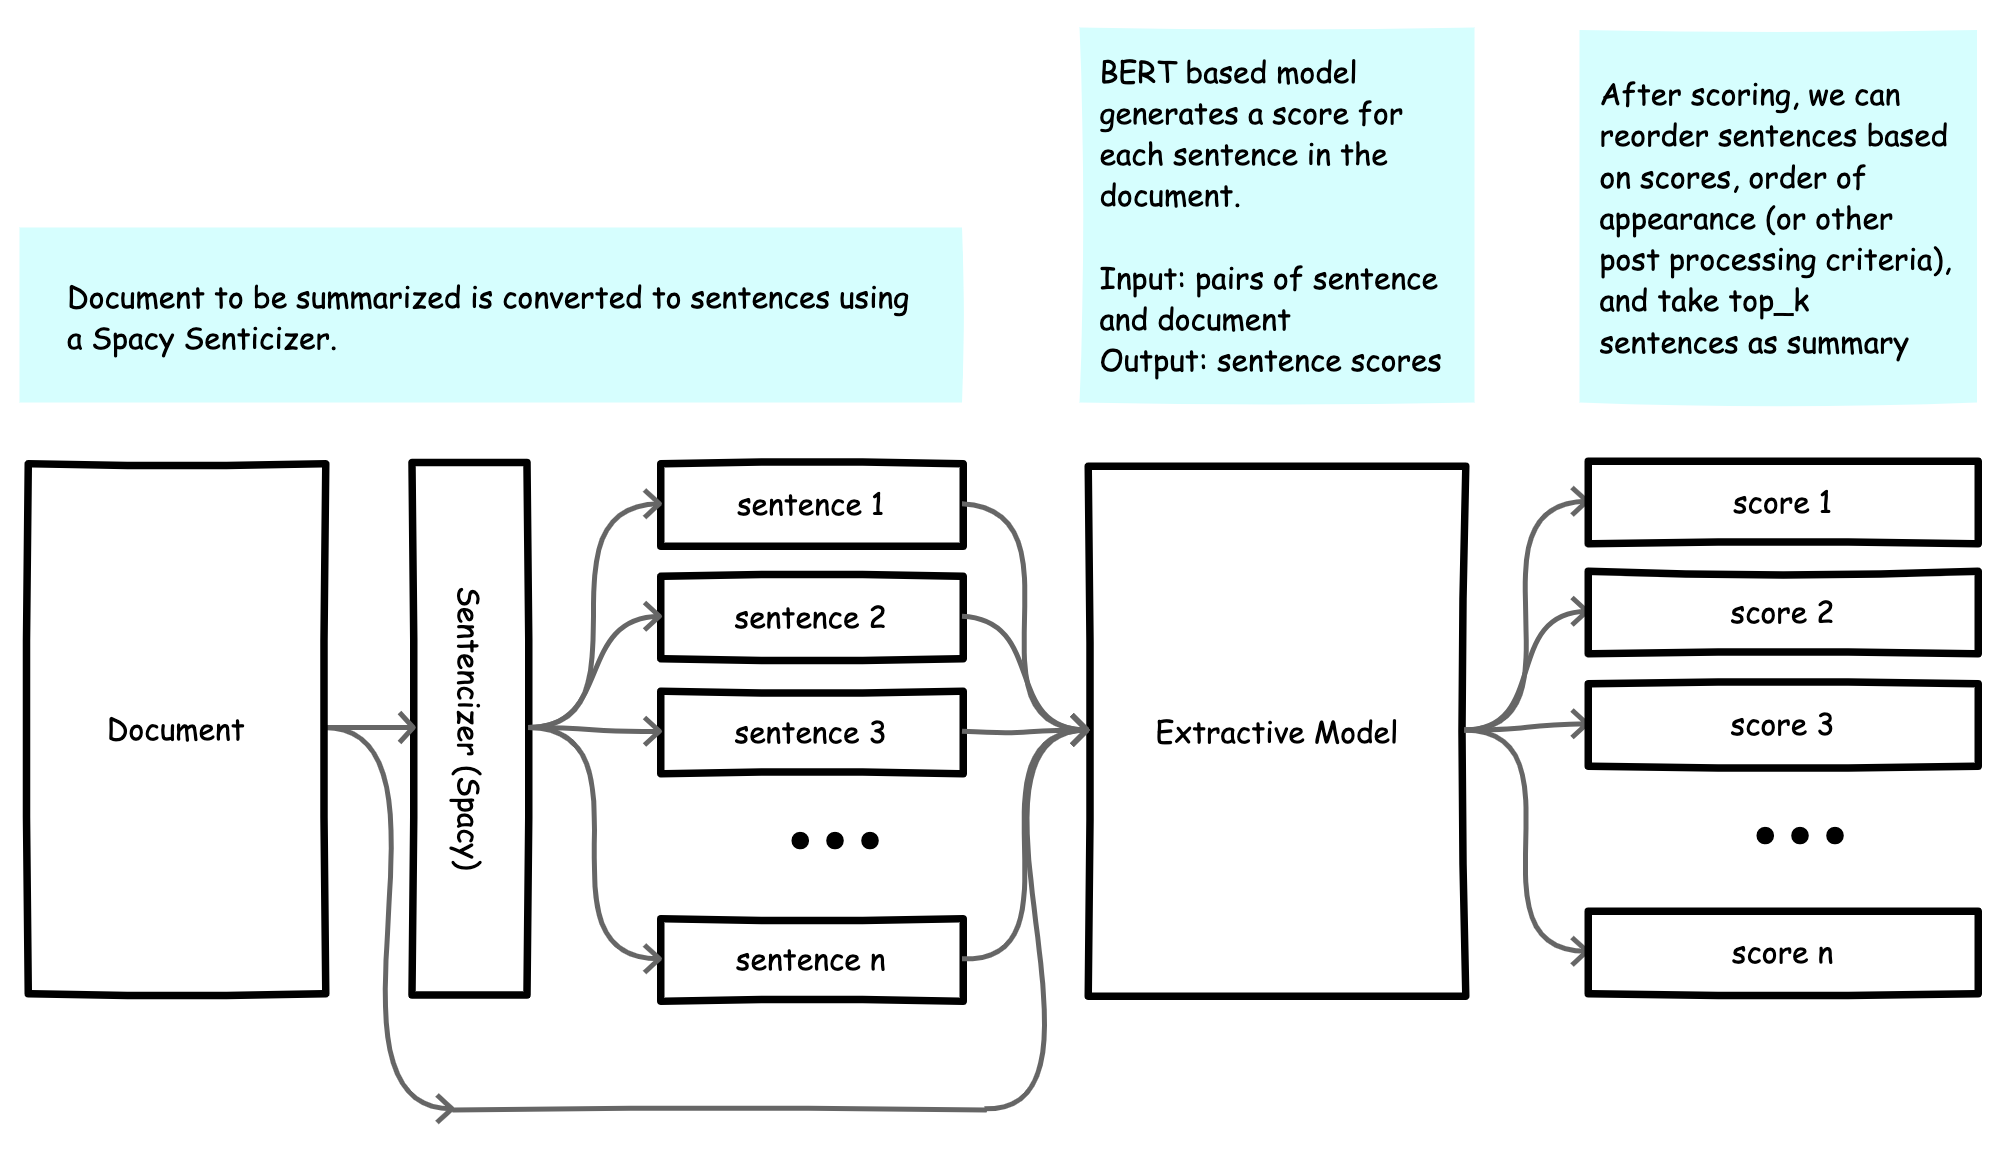

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
!pip install -q transformers  rouge-score sentence-transformers

     |████████████████████████████████| 2.6 MB 8.3 MB/s 
     |████████████████████████████████| 85 kB 5.8 MB/s 
     |████████████████████████████████| 895 kB 64.9 MB/s 
     |████████████████████████████████| 636 kB 75.2 MB/s 
     |████████████████████████████████| 3.3 MB 55.6 MB/s 
     |████████████████████████████████| 1.2 MB 61.2 MB/s 


In [ ]:
 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm
 
import plotly.express as px

import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
from transformers import AutoTokenizer, AutoModel 
nlp = spacy.load('en_core_web_lg')
## model not loading in Colab? Restart runtime after installing en_core_web_lg 

In [ ]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2"):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(384*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # get concat of both features and elementwise product
        feat_cat = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)  
        
        pooler = self.pre_classifier(feat_cat) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [ ]:
#model path .. modify to location of trained model file 
model_path = "drive/MyDrive/mlexperiments/extractivesummarization/models/minilm_bal_exsum.pth"

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

extractive_model = SentenceBertClass() 
extractive_model.load_state_dict(torch.load(model_path, map_location=torch.device(device) ))
extractive_model.eval(); 

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

## Extractive Summarization Inference 



In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L3-v2')

# tokenize text as required by BERT based models
def get_tokens(text, tokenizer):
  inputs = tokenizer.batch_encode_plus(
            text, 
            add_special_tokens=True,
            max_length=512,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
  ids = inputs['input_ids']
  mask = inputs['attention_mask']
  return ids, mask

Downloading:   0%|          | 0.00/516 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# get predictions given some an array of sentences and their corresponding documents
def predict(model,sents, doc):
  sent_id, sent_mask = get_tokens(sents,tokenizer)
  sent_id, sent_mask = torch.tensor(sent_id, dtype=torch.long),torch.tensor(sent_mask, dtype=torch.long)
 
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * len(sents), doc_mask* len(sents)
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  preds = model(sent_id, doc_id, sent_mask, doc_mask)
  return preds

In [ ]:
def summarize(doc, model, min_sentence_length=14, top_k=3, batch_size=3):
  doc = doc.replace("\n","")
  doc_sentences = []
  for sent in nlp(doc).sents:
    if len(sent) > min_sentence_length: 
      doc_sentences.append(str(sent))
  
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * batch_size, doc_mask* batch_size
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  scores = [] 
  # run predictions using some batch size
  for i in tqdm(range(int(len(doc_sentences) / batch_size) + 1)):
    batch_start = i*batch_size  
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)-1
    batch = doc_sentences[batch_start: batch_end]
    if batch:
      preds = predict(model, batch, doc) 
      scores = scores + preds.tolist() 
 
  sent_pred_list = [{"sentence": doc_sentences[i], "score": scores[i][0], "index":i} for i in range(len(doc_sentences))]
  sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True) 

  sorted_result = sorted_sentences[:top_k] 
  sorted_result = sorted(sorted_result, key=lambda k: k['index']) 
  
  summary = [ x["sentence"] for x in sorted_result]
  summary = " ".join(summary)

  return summary, scores, doc_sentences


In [ ]:
article = """ Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. There are about ten thousand living species, more than half of which are passerine, or “perching” birds. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. Wings, which evolved from forelimbs, gave birds the ability to fly, although further evolution has led to the loss of flight in some birds, including ratites, penguins, and diverse endemic island species. The digestive and respiratory systems of birds are also uniquely adapted for flight. Some bird species of aquatic environments, particularly seabirds and some waterbirds, have further evolved for swimming. Birds are feathered theropod dinosaurs and constitute the only known living dinosaurs. Likewise, birds are considered reptiles in the modern cladistic sense of the term, and their closest living relatives are the crocodilians. Birds are descendants of the primitive avialans (whose members include Archaeopteryx) which first appeared about 160 million years ago (mya) in China. According to DNA evidence, modern birds (Neornithes) evolved in the Middle to Late Cretaceous, and diversified dramatically around the time of the Cretaceous–Paleogene extinction event 66 mya, which killed off the pterosaurs and all known non-avian dinosaurs. Many social species pass on knowledge across generations, which is considered a form of culture. Birds are social, communicating with visual signals, calls, and songs, and participating in such behaviours as cooperative breeding and hunting, flocking, and mobbing of predators. The vast majority of bird species are socially (but not necessarily sexually) monogamous, usually for one breeding season at a time, sometimes for years, but rarely for life. Other species have breeding systems that are polygynous (one male with many females) or, rarely, polyandrous (one female with many males). Birds produce offspring by laying eggs which are fertilised through sexual reproduction. They are usually laid in a nest and incubated by the parents. Most birds have an extended period of parental care after hatching. Many species of birds are economically important as food for human consumption and raw material in manufacturing, with domesticated and undomesticated birds being important sources of eggs, meat, and feathers. Songbirds, parrots, and other species are popular as pets. Guano (bird excrement) is harvested for use as a fertiliser. Birds figure throughout human culture. About 120 to 130 species have become extinct due to human activity since the 17th century, and hundreds more before then. Human activity threatens about 1,200 bird species with extinction, though efforts are underway to protect them. Recreational birdwatching is an important part of the ecotourism industry. """

In [ ]:
article

' Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. There are about ten thousand living species, more than half of which are passerine, or “perching” birds. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. Wings, which evolved from forelimbs, gave birds the ability to fly, although further evolution has led to the loss of flight in some birds, including ratites, penguins, and diverse endemic island species. The digestive and respiratory systems of birds are also uniquely adapted for flight. Some bird species of aquatic environments, particularly seabirds and some waterbirds, have furt

## Inference - Generate Extractive Summary

- Perform inference
- Make sense of model results by visualizing scores assigned to each sentence.

In [ ]:
summary, scores, sentences = summarize(article, extractive_model, min_sentence_length=14, top_k=3, batch_size=4)
summary

  0%|          | 0/5 [00:00<?, ?it/s]

'Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. According to DNA evidence, modern birds (Neornithes) evolved in the Middle to Late Cretaceous, and diversified dramatically around the time of the Cretaceous'

Among them were Navy medic Max Soviak, and Marines Hunter Lopez, Rylee McCollum, David Lee Espinoza, Kareem Nikoui, Jared Schmitz, Ryan Knauss, Daegan Page, Taylor Hoover and an unnamed special forces soldier. McCollum's wrestling coach and a close family friend told DailyMail.com that 'heads should roll' over the debacle. McCollum was named by his high school in Wyoming while Espinoza, 20, was named by the local police department in Laredo, Texas, where he was born.

## Visualize Scores Assigned to Each Sentence  

A visualization of the scores assigned by the model can help us "make sense" of model behaviour. 

- is the model weighting each sentence equally or focusing on some sentences? (ideally, we want to see good variation). 


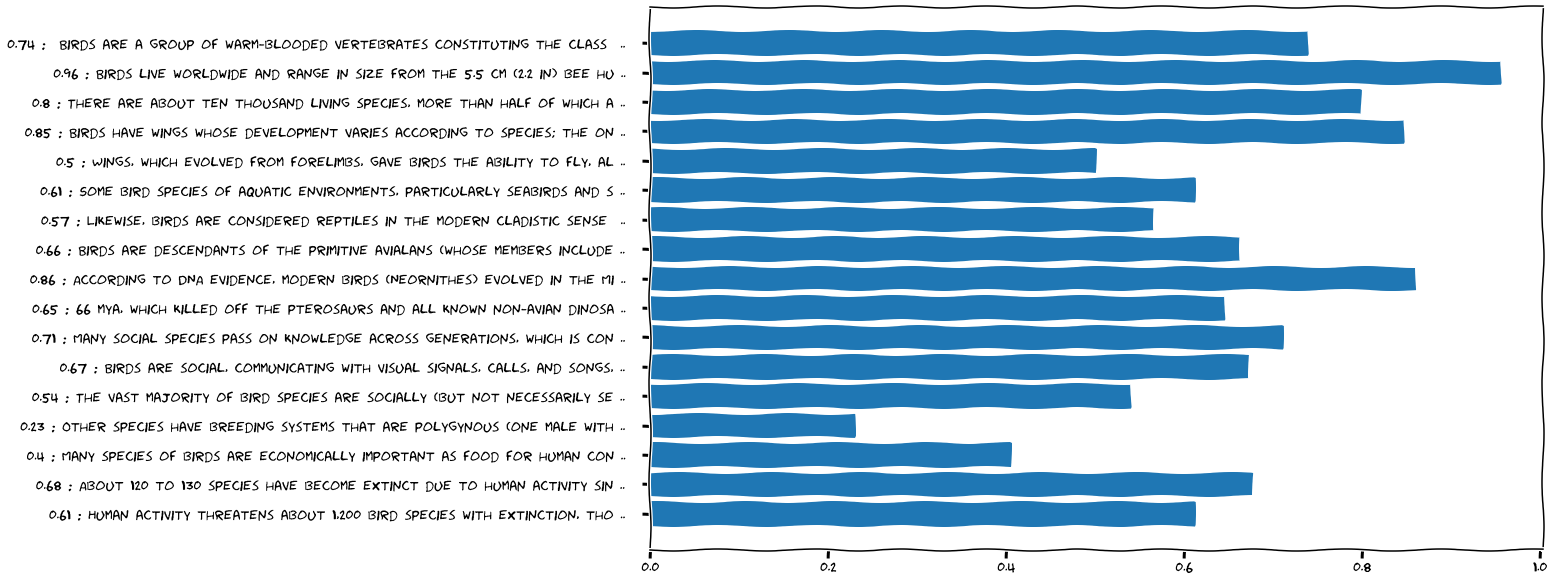

In [ ]:
sent_lenth = 70
score_vals = ([x[0] for x in scores] ) 
sub_sents = [ str(round(score_vals[i],2)) + " : " + sentences[i][:sent_lenth] + " ..  " for i in range(len(sentences))] 
with plt.xkcd():
    plt.figure(figsize=(16,10));
    plt.barh(sub_sents[::-1], score_vals[::-1]);

## Scrape some Tech News and Summarize 

- Get a list of articles on front page of TechCrunch news
- Get each article's title, and content using urlib and beatifulsoup.

In [ ]:
from bs4 import BeautifulSoup
import urllib.request

import json

def save_json(data, file_path): 
  with open(file_path, 'w', encoding='utf-8') as f:
      json.dump(data, f, ensure_ascii=False, indent=4)

In [ ]:
def get_article(page_url):
  page =  urllib.request.urlopen(page_url)
  soup = BeautifulSoup(page, "html.parser")
  content = soup.find("div", attrs={"class": "article-content"})
  content = content.text.replace("\n","").replace("\xa0","").strip()
  return content

main_page =  urllib.request.urlopen("https://techcrunch.com/")
articles = BeautifulSoup(main_page, "html.parser")
articles = articles.find("div", attrs={"id": "root"}).find_all("a", attrs={"class": "post-block__title__link"})

article_contents = [ get_article(x["href"]) for x in articles] 
article_titles = [ x.text.replace("\t","").strip() for x in articles] 

## Abstractive Summarization with HF for Comparison

In [ ]:
from transformers import pipeline
from tqdm.notebook import tqdm
ab_summarizer = pipeline("summarization", model="t5-base")
import re 


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

abs_model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
abs_tokenizer = AutoTokenizer.from_pretrained("t5-base")



In [ ]:
def abstractive_summarize(doc,  max_length=250, min_length=50, batch_size=2):
  all_sum=[]
  # batched prediction
  for i in tqdm(range(int(len(doc) / batch_size) + 1)): 
    batch_start = i*batch_size  
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)
    batch = ["summarize: " + x for x in doc[batch_start: batch_end]]   
    if (batch):
      inputs = abs_tokenizer.batch_encode_plus( batch, return_tensors="pt", max_length=512, truncation=True) 
      outputs = abs_model.generate(inputs["input_ids"], max_length=max_length, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
      output = [re.sub(r'<([^>]*)>', "", abs_tokenizer.decode(x))  for x in outputs.tolist()]  
      all_sum = all_sum + output 
  return all_sum

In [ ]:
ab_summary = abstractive_summarize(article_contents)

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning:

floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)



In [ ]:
 (ab_summary)

[" Clubhouse's Justin Uberti is the head of streaming technology at the social audio app. he joined the company in may as its head of streaming technology after more than a decade at google where he created Google Duo.",
 ' regulators are now going after the exploitative use of algorithm-powered user recommendations. Xiaomi is acquiring an autonomous vehicle startup called Deepmotion. ByteDance is said to be buying virtual reality hardware startup Pico.',
 ' mark Zuckerberg is, undoubtedly, the greatest technologist of our time. in 1972, executives of the era’s preeminent technology company — AT&T — met at a secret retreat in key largo, florida. a consent decree forced AT&T’s dismantling.',
 ' a coalition of silicon valley law firms and startup vendors is forming to address this issue. the open cap table coalition stated its intention to “improve the interoperability, transparency, and portability of startup cap table data”.',
 ' many founders of VC-backed startups are white, male, and

In [ ]:
ex_summary =  [summarize(x, extractive_model)[0] for x in article_contents ]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
ex_summary

['While Clubhouse and other voice chat apps bring people together in virtual social settings, the audio generally sounds relatively flat, like it’s emanating from a single central location. The new audio features will roll out Sunday to the majority of iOS users, reaching the rest of Clubhouse’s iOS and Android users within the next few weeks. And because most people use headphones to participate on Clubhouse, most of the app’s users can benefit from the effects possible through two-channel stereo sound.',
 'Regulators are now going after the exploitative use of algorithm-powered user recommendations. Xiaomi is acquiring an autonomous vehicle startup called Deepmotion, and ByteDance is said to be buying virtual reality hardware startup Pico. Tech firms must also hand over their algorithms to the police in case of investigations.',
 'Daniel LissContributorShare on Twitter \t\tDaniel Liss is the founder and CEO of Dispo, the digital disposable camera social network.\t The Facebook monopo

In [ ]:
all_sum = [ {"title": article_titles[i], "content": article_contents[i], "abstractive": ab_summary[i], "extractive": ex_summary[i]} for i in range(len(article_contents))]
save_json(all_sum,"samples.json")

In [ ]:
df = pd.DataFrame.from_dict(all_sum)
df

,title,content,abstractive,extractive
0,Clubhouse is adding spatial audio effects to m...,It’s been a busy summer for Clubhouse. The hit...,Clubhouse's Justin Uberti is the head of stre...,While Clubhouse and other voice chat apps brin...
1,"China Roundup: Beijing takes aim at algorithm,...",Hello and welcome back toTechCrunch’s China ro...,regulators are now going after the exploitati...,Regulators are now going after the exploitativ...
2,Move fast and break Facebook: A bull case for ...,Daniel LissContributorShare on Twitter \t\tDan...,"mark Zuckerberg is, undoubtedly, the greatest...",Daniel LissContributorShare on Twitter \t\tDan...
3,A new coalition for “Open Cap Table” presents ...,Yifat AranContributorShare on Twitter \t\tDr. ...,a coalition of silicon valley law firms and s...,Dr. Yifat Aran is a visiting scholar at the Te...
4,Diversifying startups and VC power corridors,Jennifer FanContributor\t\tJennifer Fan is an ...,many founders of VC-backed startups are white...,Women-founded companies receive a fraction of ...
5,Gillmor Gang: Half a Loaf,When Salesforce announced its streaming platfo...,the CRM Playaz’s Paul Greenberg and Brent Lea...,I asked Keith Teare how quickly third party da...
6,CryptoPunks blasts past $1 billion in lifetime...,"Hello friends, and welcome back to Week in Rev...",the market for digital art on the blockchain ...,"If you’re reading this on the TechCrunch site,..."
7,Want to be a more holistic healthcare company?...,When Headspace merged with on-demand mental he...,headspace's meditation app is about as direct...,By merging with an on-demand mental healthcare...
8,This Week in Apps: Developers sound off on App...,"Welcome back to This Week inApps,the weekly Te...","the app industry continues to grow, with a re...","The app industry continues to grow, witha reco..."
9,The remote work argument has already been won ...,"Welcome back to The TechCrunch Exchange, a wee...","the debate over remote work, office culture, ...","Welcome back to The TechCrunch Exchange, a wee..."
